<a href="https://colab.research.google.com/github/shin0105/4YP/blob/master/UCI_dataset_classification_car_withplots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install GPyOpt --quiet
!pip install GPy --quiet

In [2]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

In [3]:
#dataset = UCI Car Evaluation
names=['buying','maint','doors','persons','lug_boot','safety','class']
df = pd.read_csv('car.data', names = names)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

In [5]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [6]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [7]:
#Random Forest classification

#max_features: 1 to around sqrt(# of features of dataset)
bounds = [
        {'name': 'max_features', 'type': 'continuous', 'domain': (1, 5)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (1, 200)}
      ]

def rf_score(parameters):
  params = {
        'max_features':int(parameters[0][0]),
        'n_estimators':int(parameters[0][1])
    }
  
  clf = RandomForestClassifier(max_features=params['max_features'],n_estimators=params['n_estimators'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  return score

In [8]:
def BO(model,kernel):
  optimizer = GPyOpt.methods.BayesianOptimization(f=model, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )
  optimizer.run_optimization(max_iter=100)
  #maximum accuracy score
  acc_max=optimizer.fx_opt
  #best parameters
  params_best=optimizer.x_opt
  print(acc_max)
  print(params_best)
  optimizer.plot_convergence()
  optimizer.plot_acquisition()

In [9]:
#RF Classification - Matern52 kernel
kernel = GPy.kern.Matern52(input_dim=2, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=100)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

-0.9834573002754821
[  5.         169.68732109]


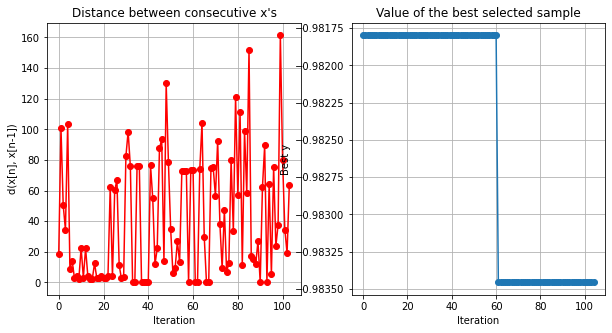

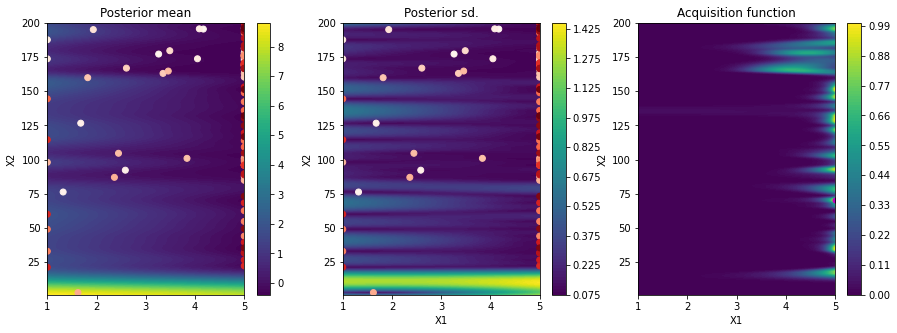

In [10]:
optimizer.plot_convergence()
optimizer.plot_acquisition()

In [12]:
rf_car = RandomForestClassifier(max_features=5,n_estimators=169)
rf_car.fit(X_train,y_train)
y_pred = rf_car.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9672447013487476


In [13]:
#SVM Classification

bounds = [ {'name': 'C', 'type': 'continuous', 'domain': (0.1, 100)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0.01, 100)}
      ]


def svm_score(parameters):
  params = {
        'C': parameters[0][0],
        'gamma':parameters[0][1]
    }
  
  clf = svm.SVC(C=params['C'],gamma=params['gamma'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)

  return score

In [14]:
#SVM Classification - Matern52 kernel
kernel = GPy.kern.Matern52(input_dim=2, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=100)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

-0.9892561983471075
[33.03807512  0.1571403 ]


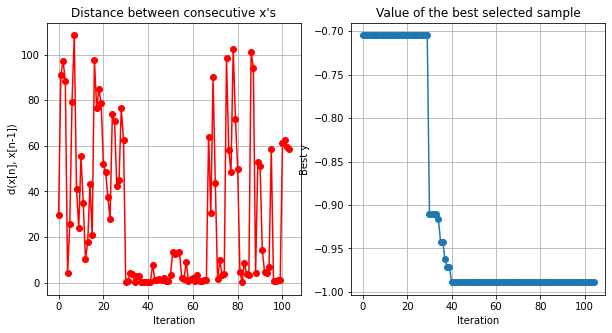

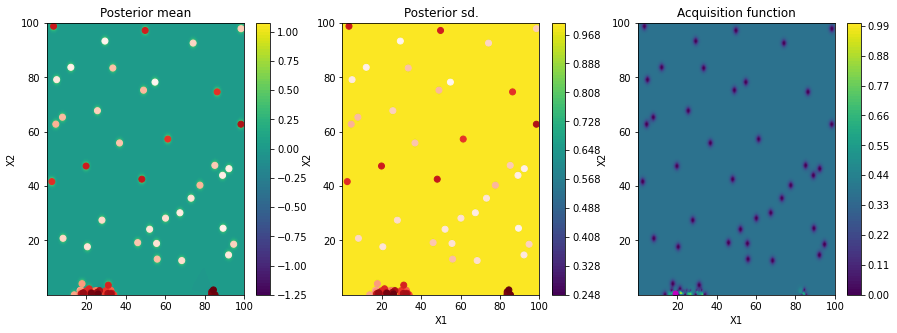

In [15]:
optimizer.plot_convergence()
optimizer.plot_acquisition()

In [16]:
SVM_car1 = svm.SVC(C=33.03807512,gamma=0.1571403)
SVM_car1.fit(X_train,y_train)
y_pred = SVM_car1.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9865125240847784


In [17]:
#KNN Classification

#search domain
bounds = [ {'name': 'leaf_size', 'type': 'continuous', 'domain': (1, 100)},
        {'name': 'n_neighbors', 'type': 'discrete', 'domain': (3,4,5,6,7)}
      ]


def knn_score(parameters):
  params = {
        'leaf_size': parameters[0][0],
        'n_neighbors':int(parameters[0][1])
    }
  
  clf = KNeighborsClassifier(leaf_size=params['leaf_size'],n_neighbors=params['n_neighbors'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)

  return score

-0.9082231404958676
[97.62853508  7.        ]


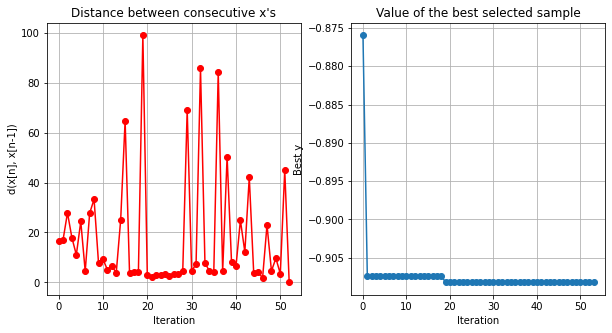

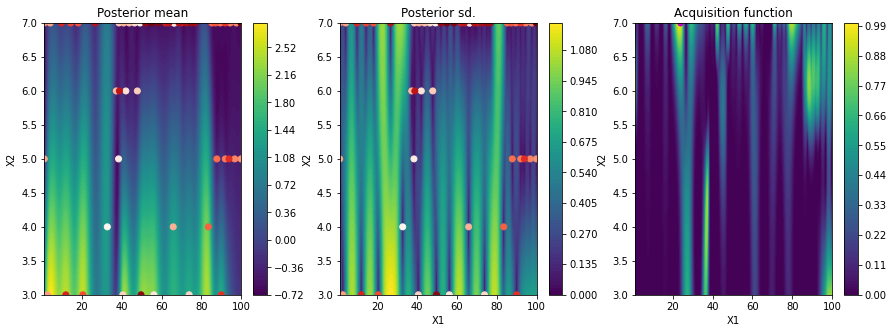

In [18]:
#KNN Classification - Matern52 kernel
kernel = GPy.kern.Matern52(input_dim=2, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=knn_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=100)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)
optimizer.plot_convergence()
optimizer.plot_acquisition()

In [19]:
KNN_car1 = KNeighborsClassifier(leaf_size=97,n_neighbors=7)
KNN_car1.fit(X_train,y_train)
y_pred = KNN_car1.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9267822736030829
